# Trajectory Generation with Adaptive-k Privacy Protection

This notebook implements experiments for generating and evaluating privacy-protected trajectories using a GRU-based model with a adaptive-k approach. 

The parameters and the algoritms are described in the paper.


##### **Imports**

In [1]:
import os
# oneDNN warning suppression TF 2.4.1
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '0'
import copy

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import tilemapbase
import statistics
import math

from typing import List, Tuple

import keras
import tensorflow as tf
from keras import Sequential

from utils.data import *
from utils.plots import *
from utils.metrics import *
from models import *
from apu_trajgen import *

import warnings
warnings.filterwarnings('ignore', category=UserWarning)

## **Experiments**

#### **Load Model and Test Data (Porto dataset)** 

In [ ]:
# Load the model generated by the training script from the 'training' folder
selected_dataset = "PORTO"

# Load the test data 
X_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_X_test.pkl") # the input trajectory data
Y_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_test.pkl") # the test trajectory data
test_seq_len = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_seq_len_test.pkl") # the sequence lenght of the input trajectory data
normalization_ranges = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_normalization_ranges.pkl") # the scaler used to normalize the data

normalization_ranges = {"min": normalization_ranges["min"][0:2], "max": normalization_ranges["max"][0:2]}

# Save the model
mdl = load_pickle( MODEL_FOLDER + "mdlgru-"+selected_dataset.lower()+".pkl")

# Model for BS = 1
model_sl = create_GRU_model(GRU_cells= LSTM_CELLS,
                          seq_len = 1,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)


# Set weights and states
model_sl.set_weights(mdl.get_weights())


#### **Experiment 1 (Porto dataset) - Point-to-point approach - Adaptive k - SU1** 

In [ ]:
# The mde_k distances are computed in the trajgen-fixed-k.py script
# They represent the MDE for k=1, k=2, k=3, and k=4 (computed for 5000 trajectories)
# These values are used to determine the adaptive k values based on the privacy and utility constraints
mde_k = [76, 257, 3585, 7185] # mean distances for k=1, k=2, k=3, and k=4

# Set values of mean_min and mean_max based on MDE_k as described in the paper
mean_min = [80, 170, 250, 350] # privacy contraint
mean_max = [155, 350, 450, 550] # utility contraint

# Set the number of trajectories to process
n_trajs = 10

save_pickle(Y_test[:n_trajs], DATA_FOLDER + selected_dataset.lower() + "_Y_test_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")
save_pickle(test_seq_len[:n_trajs], DATA_FOLDER + selected_dataset.lower() + "_test_seq_len_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")

for mmin, mmax in zip(mean_min, mean_max):
        
    # Determine the k_min and k_max values based on the mde_k distances
    # k_min is the first k value for which the MDE is greater than mmin   
    for i in range(len(mde_k)):
        if mde_k[i] > mmin:
            k_min = i+1
            break
    
    k_max = k_min + round((mmax-mmin)/mde_k[0]) + 1
    
    print("Processing trajectories with k_min = " + str(k_min) + " and k_max = " + str(k_max) + " for mean_min = " + str(mmin) + " and mean_max = " + str(mmax))        
    
    # Generate the trajectories with adaptive k
    # The function apu_trajgen_adaptive_k generates the trajectories with adaptive k values
    # It uses the compute_su_score1 function to compute the privacy and utility scores

    # The function returns the generated trajectories, the k values used, and the indices of the trajectories that were reset
    Y_pred_k, k_values, idx_reset = apu_trajgen_adaptive_k(mdl = model_sl,
                                            X_t = copy.deepcopy(X_test)[:n_trajs],
                                            test_traj_seq_lengths = test_seq_len,
                                            SEQ_LENGTH = 1,
                                            NUM_FEATS = NUM_FEATS,
                                            su_funct = compute_su_score1,
                                            su_funct_args={"mean_min": mmin, "mean_max": mmax},
                                            normalization_ranges = normalization_ranges,
                                            k_min = k_min,
                                            k_max = k_max,
                                            save_results = True,
                                            save_step = 10000,
                                            save_name= DATA_FOLDER + selected_dataset.lower() + "_Y_pred_adaptive_k_mean_min" + str(mmin) 
                                            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs))

    save_pickle(Y_pred_k, DATA_FOLDER + selected_dataset.lower() + "_Y_pred_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    save_pickle(k_values, DATA_FOLDER + selected_dataset.lower() + "_k_values_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    save_pickle(idx_reset, DATA_FOLDER + selected_dataset.lower() + "_idx_reset_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    

Processing trajectories with k_min = 2 and k_max = 5 for mean_min = 170 and mean_max = 350
Processing trajectories with k_min = 2 and k_max = 6 for mean_min = 250 and mean_max = 450
Processing trajectories with k_min = 3 and k_max = 7 for mean_min = 350 and mean_max = 550


<Figure size 640x480 with 0 Axes>

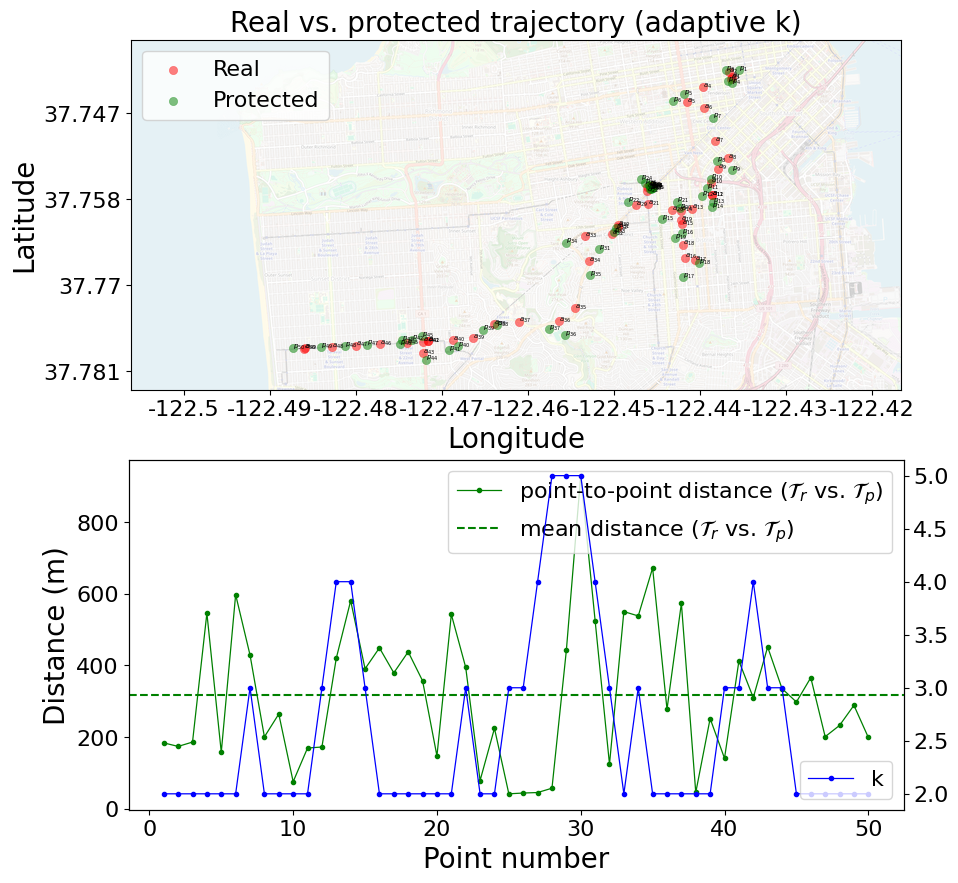

Point-to-point distance between the real and protected trajectory:
[np.float64(183.4697300621649), np.float64(173.5940229840204), np.float64(185.73906267376432), np.float64(545.4402993504735), np.float64(157.23698308847986), np.float64(597.0910328303878), np.float64(428.6918044052749), np.float64(200.21023103543467), np.float64(264.0545922056001), np.float64(75.1635664740932), np.float64(169.1192680561065), np.float64(171.920262514807), np.float64(419.9157293691668), np.float64(580.1450679324116), np.float64(390.2210879434966), np.float64(448.60764275392904), np.float64(378.88883757706924), np.float64(437.59779662204943), np.float64(356.7425447054248), np.float64(146.93204956016024), np.float64(542.0533508202889), np.float64(394.2226990108626), np.float64(78.35162769746715), np.float64(224.0455181540555), np.float64(41.32073562972907), np.float64(43.49525237016922), np.float64(44.89126928317948), np.float64(56.93344332119046), np.float64(441.6190416852077), np.float64(929.2749046454618

<Figure size 640x480 with 0 Axes>

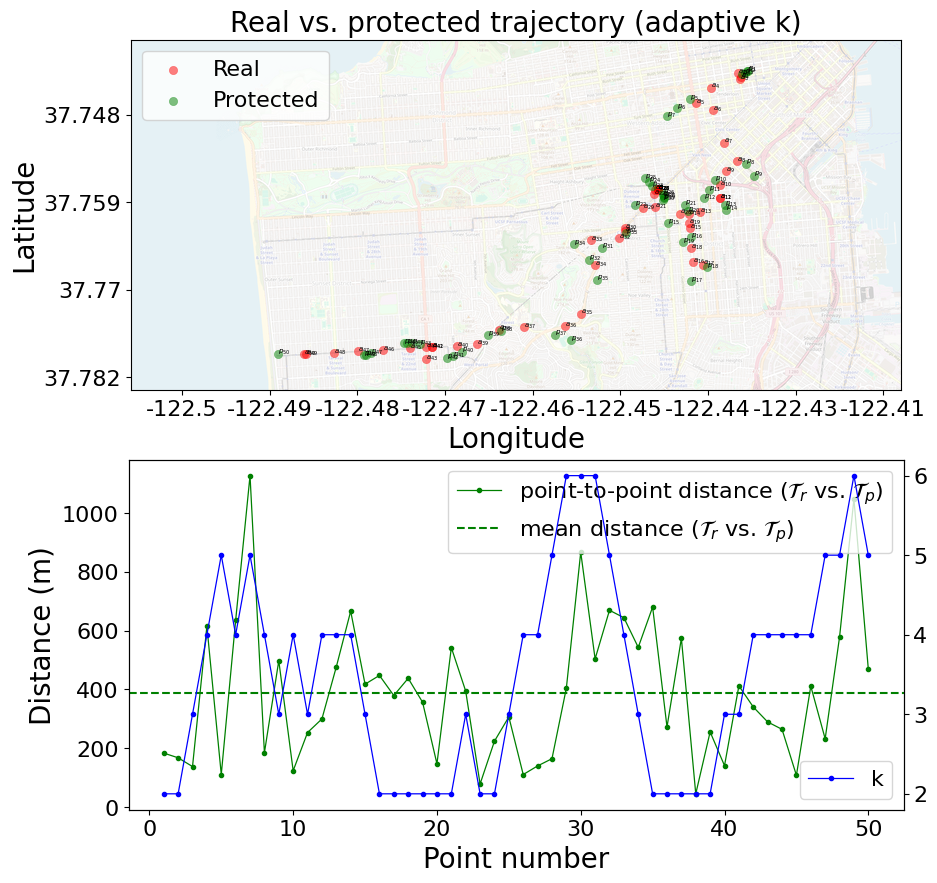

Point-to-point distance between the real and protected trajectory:
[np.float64(183.4697300621649), np.float64(167.54387268993054), np.float64(137.65065111774706), np.float64(614.986785938957), np.float64(110.64059699246724), np.float64(634.7715000882351), np.float64(1127.3131738508416), np.float64(184.4734043417954), np.float64(497.64301925829193), np.float64(123.53379310230346), np.float64(253.3672402288507), np.float64(299.66382152944544), np.float64(476.6380444308112), np.float64(666.1356708261656), np.float64(417.8723821865721), np.float64(447.6368404444069), np.float64(379.33821758878014), np.float64(437.85881142874365), np.float64(356.5538279437216), np.float64(147.10148079144187), np.float64(542.3551170581666), np.float64(394.24722655720444), np.float64(78.36803214632579), np.float64(224.04305818397097), np.float64(306.5609198328463), np.float64(110.53322042518451), np.float64(139.8249869552276), np.float64(164.37057220186034), np.float64(404.2935583420204), np.float64(866.64019

<Figure size 640x480 with 0 Axes>

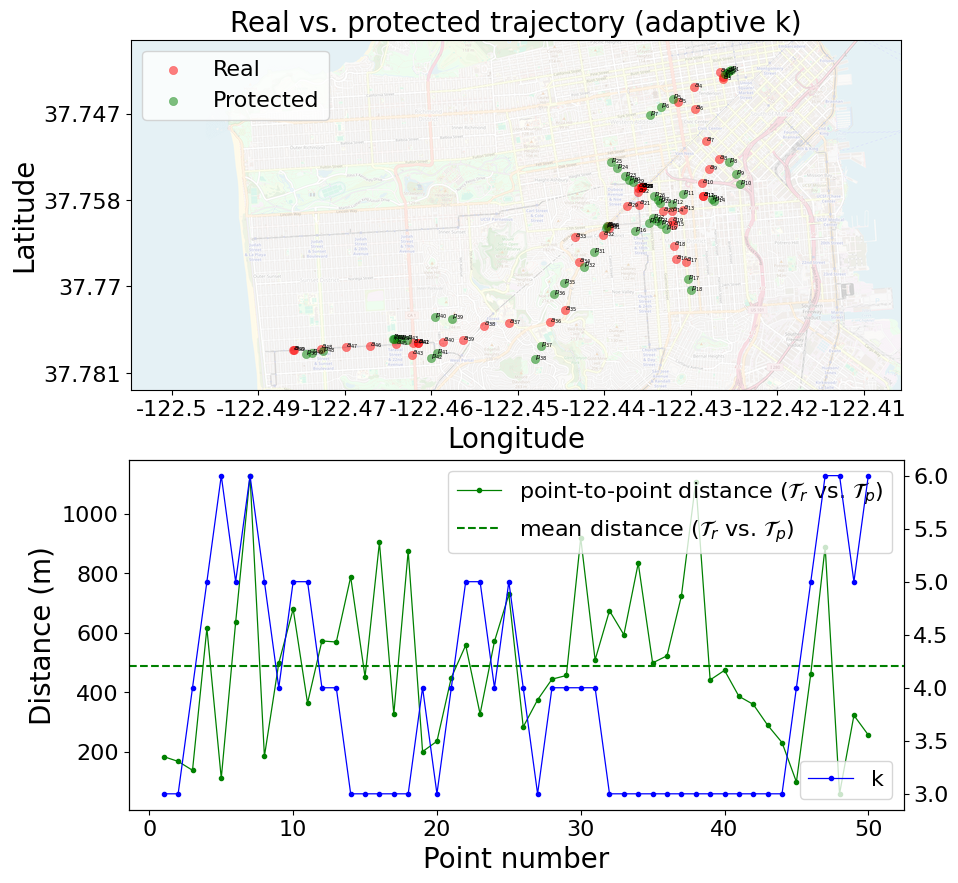

Point-to-point distance between the real and protected trajectory:
[np.float64(183.4697300621649), np.float64(167.54387268993054), np.float64(137.65065111774706), np.float64(614.986785938957), np.float64(110.64059699246724), np.float64(634.7715000882351), np.float64(1127.3131738508416), np.float64(184.4734043417954), np.float64(497.64301925829193), np.float64(679.4496034291913), np.float64(363.3724110452106), np.float64(572.0796365646379), np.float64(568.5083326244564), np.float64(787.0541489043625), np.float64(451.33763897959005), np.float64(902.9346375758886), np.float64(326.0025878956999), np.float64(874.3969843115549), np.float64(200.4017584366158), np.float64(235.1557332960762), np.float64(449.09680772426293), np.float64(557.679682983459), np.float64(326.7075443652944), np.float64(570.6555292704592), np.float64(728.2050098316089), np.float64(283.297484169645), np.float64(374.3166237072923), np.float64(443.6757818733347), np.float64(456.0514207186794), np.float64(917.5545971233906)

In [7]:
# Select a trajectory to visualize
traj_idx = 5

# Load the data and plot trajectory with id=traj_idx
Y_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_test_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")
test_seq_len = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_test_seq_len_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")
Y_test_dn = denormalize_data(dataset = copy.deepcopy(Y_test), normalization_ranges = normalization_ranges)

for mmin, mmax in zip(mean_min, mean_max):

    for i in range(len(mde_k)):
        if mde_k[i] > mmin:
                k_min = i+1
                break
    k_max = k_min + round((mmax-mmin)/mde_k[0]) + 1
    
    Y_pred_k = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_pred_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    k_values = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_k_values_adaptive_k_mean_min" + str(mmin)
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    idx_reset = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_idx_reset_adaptive_k_mean_min" + str(mmin)
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    # Denormalize the data using the scaler or normalization ranges
    Y_pred_k_dn = denormalize_data(dataset = Y_pred_k, normalization_ranges = normalization_ranges) 
    
    dists_k = compute_point_to_point_haversine_distances(Y_test_dn[traj_idx][0:test_seq_len[traj_idx]], Y_pred_k_dn[traj_idx])
    
    # Plot the trajectory with adaptive k values
    lons_min_ext, lons_max_ext, lats_min_ext, lats_max_ext = plot_trajectory_adaptive_k(real_traj = Y_test_dn[traj_idx][0:test_seq_len[traj_idx]],
                        protected_traj = Y_pred_k_dn[traj_idx],
                        dists = dists_k,
                        save=True,
                        adaptive=True, 
                        aspect_ratio=2.2,
                        ks = k_values[traj_idx],
                        idx_reset = None,
                        savePath = "_porto_mean_min" + str(mmin) + "_mean_max" + str(mmax) + "_trajid_" + str(traj_idx))

    print("Point-to-point distance between the real and protected trajectory:")
    print (dists_k)
    print("Min/max longitudes and latitudes of the trajectories:")
    print(lons_min_ext, lons_max_ext, lats_min_ext, lats_max_ext)
    print("##################################")
    print("Targeted mean: ")
    print("Mean min: " + str(mmin) + " / Mean max: " + str(mmax))
    print("k_min: " + str(k_min) + " / k_max: " + str(k_max))
    print("Mean distance between the real and protected trajectory:")
    print(np.mean(dists_k))
    print("##################################")

#### **Load Model and Test Data (SanFrancisco dataset)** 

In [10]:
# Load the model generated by the training script from the 'training' folder
selected_dataset = "SANFRANCISCO"

# Load the test data
X_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_X_test.pkl") # the input trajectory data
Y_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_test.pkl") # the test trajectory data
test_seq_len = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_seq_len_test.pkl") # the sequence lenght of the input trajectory data
normalization_ranges = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_normalization_ranges.pkl") # the scaler used to normalize the data

normalization_ranges = {"min": normalization_ranges["min"][0:2], "max": normalization_ranges["max"][0:2]}

# Load the model
mdl = load_pickle( MODEL_FOLDER + "mdlgru-"+selected_dataset.lower()+".pkl")

# Model for BS = 1
model_sl = create_GRU_model(GRU_cells= LSTM_CELLS,
                          seq_len = 1,
                          num_feat = NUM_FEATS,
                          batch_size = 1,
                          stateful = True,
                          return_seq = RETURN_SEQ,
                          num_outputs = NUM_OUTPUTS,
                          LR = LR,
                          SEED = SEED,
                          ragged = False)


# Set weights and states
model_sl.set_weights(mdl.get_weights())

#### **Experiment 2 (SanFrancisco dataset) - Point-to-point approach - Adaptive k - SU1** 

In [11]:
# The mde_k distances are computed in the trajgen-fixed-k.py script
# They represent the MDE for k=1, k=2, k=3, and k=4 (computed for 5000 trajectories)
# These values are used to determine the adaptive k values based on the privacy and utility constraints
mde_k = [168, 286, 489, 824]

mean_min = [170, 250, 350] # privacy contraint
mean_max = [350, 450, 550] # utility contraint

# Set the number of trajectories to process
n_trajs = 10

save_pickle(Y_test[:n_trajs], DATA_FOLDER + selected_dataset.lower() + "_Y_test_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")
save_pickle(test_seq_len[:n_trajs], DATA_FOLDER + selected_dataset.lower() + "_test_seq_len_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")

for mmin, mmax in zip(mean_min, mean_max):
        
    for i in range(len(mde_k)):
        if mde_k[i] > mmin:
                k_min = i+1
                break
    k_max = k_min + round((mmax-mmin)/mde_k[0]) + 1
    
    print("Processing trajectories with k_min = " + str(k_min) + " and k_max = " + str(k_max) + " for mean_min = " + str(mmin) + " and mean_max = " + str(mmax))        
    
    Y_pred_k, k_values, idx_reset = apu_trajgen_adaptive_k(mdl = model_sl,
                                            X_t = copy.deepcopy(X_test)[:n_trajs],
                                            test_traj_seq_lengths = test_seq_len,
                                            SEQ_LENGTH = 1,
                                            NUM_FEATS = NUM_FEATS,
                                            su_funct = compute_su_score1,
                                            su_funct_args={"mean_min": mmin, "mean_max": mmax},
                                            normalization_ranges = normalization_ranges,
                                            k_min = k_min,
                                            k_max = k_max)

    save_pickle(Y_pred_k, DATA_FOLDER + selected_dataset.lower() + "_Y_pred_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    save_pickle(k_values, DATA_FOLDER + selected_dataset.lower() + "_k_values_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    save_pickle(idx_reset, DATA_FOLDER + selected_dataset.lower() + "_idx_reset_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    

Processing trajectories with k_min = 2 and k_max = 4 for mean_min = 170 and mean_max = 350
Processing trajectories with k_min = 2 and k_max = 4 for mean_min = 250 and mean_max = 450
Processing trajectories with k_min = 3 and k_max = 5 for mean_min = 350 and mean_max = 550


<Figure size 640x480 with 0 Axes>

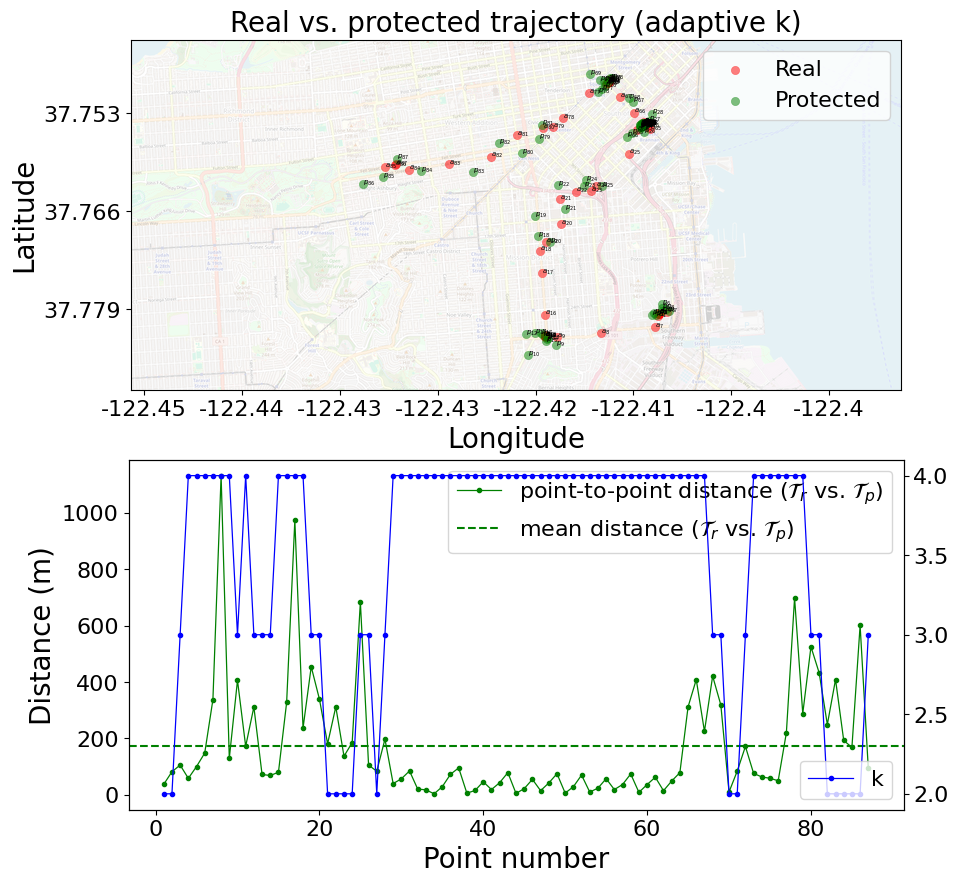

Point-to-point distance between the real and protected trajectory:
[np.float64(37.179122531416645), np.float64(81.70917655457563), np.float64(105.40129029913051), np.float64(58.27501924003527), np.float64(100.19296699696142), np.float64(147.87620361091388), np.float64(337.35475144653793), np.float64(1131.9009434376842), np.float64(128.87154137848503), np.float64(405.9786453628091), np.float64(171.9085734849629), np.float64(311.5611942866687), np.float64(71.94984956890461), np.float64(68.47914344241731), np.float64(79.87981179513169), np.float64(327.557641634253), np.float64(973.4477788081086), np.float64(236.25104900490393), np.float64(454.2149173562782), np.float64(339.4322417119513), np.float64(180.90115329450305), np.float64(312.0608631404362), np.float64(136.6719201644277), np.float64(185.1470095012988), np.float64(683.5160432832598), np.float64(105.59028206760189), np.float64(83.34339686636648), np.float64(197.46412375880809), np.float64(39.7474476056146), np.float64(56.5521710413

<Figure size 640x480 with 0 Axes>

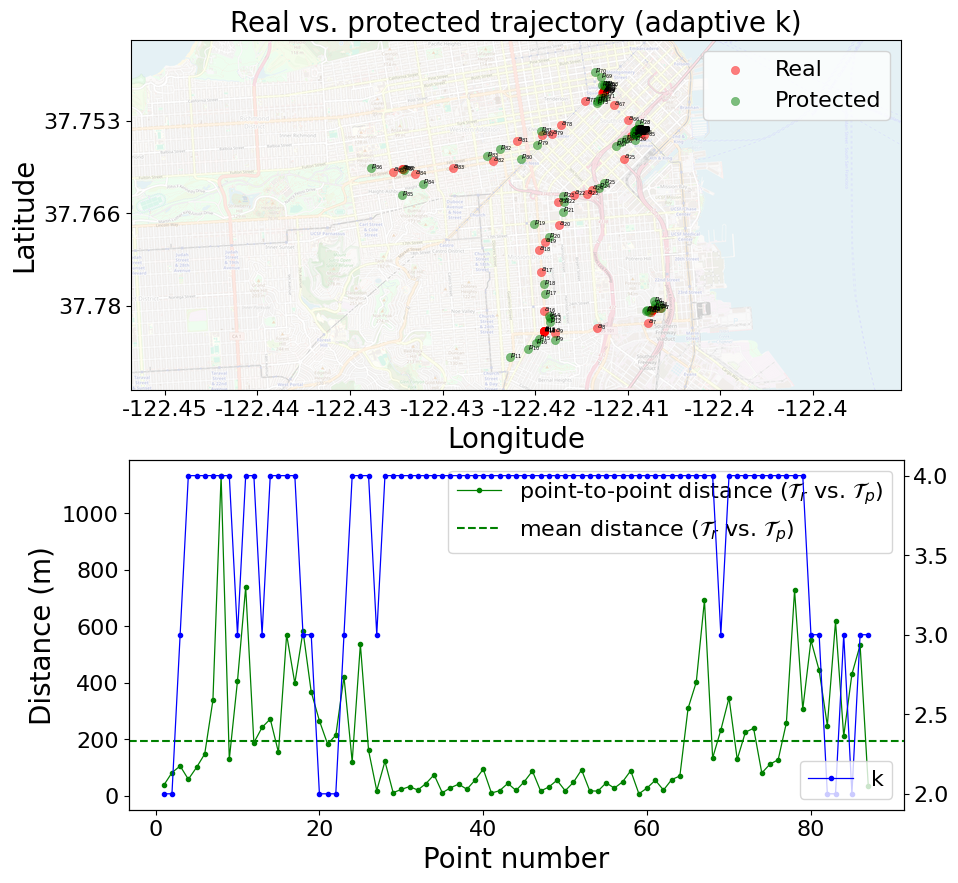

Point-to-point distance between the real and protected trajectory:
[np.float64(37.179122531416645), np.float64(81.70917655457563), np.float64(105.40129029913051), np.float64(58.27501924003527), np.float64(100.19296699696142), np.float64(147.87620361091388), np.float64(337.35475144653793), np.float64(1131.9009434376842), np.float64(128.87154137848503), np.float64(405.9786453628091), np.float64(737.55272725607), np.float64(187.6012734772497), np.float64(241.691648185999), np.float64(271.4425906639218), np.float64(153.42614953302336), np.float64(569.8288098472099), np.float64(397.7224579208094), np.float64(581.8680588505226), np.float64(367.1070249512615), np.float64(265.1567477647394), np.float64(182.82463412513147), np.float64(213.96734131442574), np.float64(420.634645894572), np.float64(120.42580346238779), np.float64(535.1929095386337), np.float64(160.4006858330146), np.float64(18.207729435408393), np.float64(121.74636170337627), np.float64(11.110770284629277), np.float64(22.418045486

<Figure size 640x480 with 0 Axes>

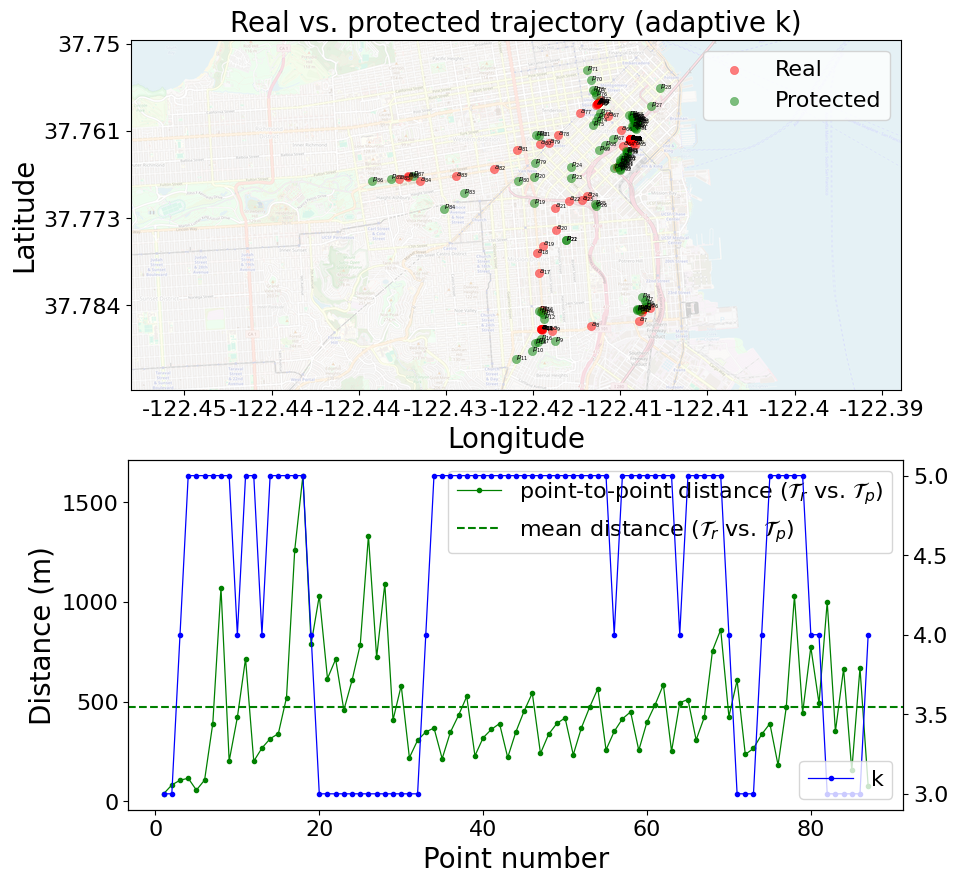

Point-to-point distance between the real and protected trajectory:
[np.float64(37.179122531416645), np.float64(81.70917655457563), np.float64(105.40129029913051), np.float64(115.345072136514), np.float64(55.773621777154915), np.float64(106.31286995781993), np.float64(389.45441999331905), np.float64(1069.545632123331), np.float64(201.67363328247134), np.float64(420.95671502128494), np.float64(714.9532683365476), np.float64(200.75424612162396), np.float64(266.6568969291212), np.float64(313.6633140281614), np.float64(338.90416065496754), np.float64(520.1338788151492), np.float64(1258.8091116329833), np.float64(1633.178112361706), np.float64(787.0393893410545), np.float64(1030.232534452738), np.float64(615.4762649501469), np.float64(712.6051546291992), np.float64(457.1354472394342), np.float64(606.0730478394355), np.float64(785.7195256575446), np.float64(1331.504533863873), np.float64(721.7660220148143), np.float64(1090.355861027403), np.float64(407.2960443304187), np.float64(580.089010584

In [13]:
# Select a trajectory to visualize
traj_idx = 8

# Load the data and plot trajectory with id=traj_idx
Y_test = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_test_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")
test_seq_len = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_test_seq_len_adaptive_k_ntrajs_" + str(n_trajs) + ".pkl")
Y_test_dn = denormalize_data(dataset = copy.deepcopy(Y_test), normalization_ranges = normalization_ranges)

for mmin, mmax in zip(mean_min, mean_max):

    for i in range(len(mde_k)):
        if mde_k[i] > mmin:
                k_min = i+1
                break
    k_max = k_min + round((mmax-mmin)/mde_k[0]) + 1
    
    Y_pred_k = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_Y_pred_adaptive_k_mean_min" + str(mmin) 
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    k_values = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_k_values_adaptive_k_mean_min" + str(mmin)
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    idx_reset = load_pickle(DATA_FOLDER + selected_dataset.lower() + "_idx_reset_adaptive_k_mean_min" + str(mmin)
            + "_mean_max" + str(mmax) + "_ntrajs_" + str(n_trajs) + ".pkl")
    
    # Denormalize the data using the scaler or normalization ranges
    Y_pred_k_dn = denormalize_data(dataset = Y_pred_k, normalization_ranges = normalization_ranges) 
    
    dists_k = compute_point_to_point_haversine_distances(Y_test_dn[traj_idx][0:test_seq_len[traj_idx]], Y_pred_k_dn[traj_idx])
    
    lons_min_ext, lons_max_ext, lats_min_ext, lats_max_ext = plot_trajectory_adaptive_k(real_traj = Y_test_dn[traj_idx][0:test_seq_len[traj_idx]],
                        protected_traj = Y_pred_k_dn[traj_idx],
                        dists = dists_k,
                        save=True,
                        adaptive=True, 
                        aspect_ratio=2.2,
                        ks = k_values[traj_idx],
                        idx_reset = None,
                        savePath = "_sanfrancisco_mean_min" + str(mmin) + "_mean_max" + str(mmax) + "_trajid_" + str(traj_idx))
    print("Point-to-point distance between the real and protected trajectory:")
    print (dists_k)
    print("Min/max longitudes and latitudes of the trajectories:")
    print(lons_min_ext, lons_max_ext, lats_min_ext, lats_max_ext)
    print("##################################")
    print("Targeted mean: ")
    print("Mean min: " + str(mmin) + " / Mean max: " + str(mmax))
    print("k_min: " + str(k_min) + " / k_max: " + str(k_max))
    print("Mean distance between the real and protected trajectory:")
    print(np.mean(dists_k))
    print("##################################")